## Persian Affiliations

این مقادیر ثابت تعریف شده باید با توجه به مکان قرارگیری داده های پروژه، و فرمت نامگذاری فایل های مربوطه تغییر کنند

annotations dir: محل ذخیره ی فایل های نشانه گذاری شده

json name format: نحوه ی نام گذاری فایل های جیسون

papers text dir: محل ذخیره ی فایل های متنی صفحه ی اول مقالات

text name format: نحوه ی نام گذاری فایل های متنی

In [1]:
ANNOTATIONS_DIR = 'annotations/'
JSON_NAME_FORMAT = 'metadata_ paper{number}.json'

PAPERS_TEXT_DIR = 'train/'
TXT_NAME_FORMAT = '{number}.txt'

تابع ارزش دهی به رشته های تک خطی بر اساس وجود کلمات مدنظر

In [2]:
def count_affiliation_related_words(line):
    """
    Measurement of affiliation value
    
    Parameters
    ----------
    line : string
        A line in paper
        
    Returns
    -------
    int
        Value
    """
    affiliation_related_words = ['دانشگاه', 'استاد', 'کارشناسی', 'ارشد', 'دکتری',\
                                 'دانشکده', 'هیئت علمی', 'هیأت علمی', 'گروه', 'نویسنده'\
                                 'رشته', 'مربی', 'استادیار', 'دانشیار', 'استاد تمام',\
                                 'مدرس', 'دبیر', 'مکاتبات', 'پژوهشگاه', 'پژوهشگر'] # bunch of related words
    cnt = 0
    for arw in affiliation_related_words: # for each affiliation related value
        if arw in line: # check if this line has that word
            cnt += 1
    return cnt+1 if 'استان' in line or 'شهرستان' in line or 'علمی' in line else cnt

پیدا کردن شماره ی مقالات موجود در پوشه ی مربوط

In [3]:
import os
import re

paper_numbers = [re.search(r'\b\d+\b', s).group() for s in \
                 [file_name for file_name in sorted(os.listdir(PAPERS_TEXT_DIR))]] # find files in directory and sort by name
print(paper_numbers)

['1', '14', '167', '171', '172', '20', '201', '24', '25', '26', '28', '3', '42', '43', '465', '468', '469', '472', '473', '474', '478', '479', '480', '481', '6', '601', '62', '66', '69', '7', '70', '71', '8', '9', '98']


استفاده از تابع تطابق دنباله ها برای مقایسه ی میزان شباهت رشته هایی که از طریق جستجو بدست می آیند با رشته هایی که تگ گذاری شده بودند

In [4]:
import difflib
difflib.SequenceMatcher(None, 'example text', 'sample text').ratio() # two strings similarity ratio

0.8695652173913043

تابع حذف علامت های اضافه از نتایج بدست آمده

In [5]:
def cleaned_result(s):
    """
    Eliminate useless signs from affiliation
    
    Parameters
    ----------
    s : string
        Detected affiliation
        
    Returns
    -------
    string
        Cleaned affiliation
    """
    s = s.replace('ك', 'ک').replace('ي', 'ی') # change arabic letters to persian ones
    signs = ['۱-', '۲-', '۳-', '۴-', '۵-', '1-',\
             '2-', '3-', '4-', '5-', 'email', 'mail',\
             '*', 'پست الکترونیکی', 'ایمیل', 'پست الکترونیک',\
             'رایانامه', ':', ';', '\"', '\'', 'I', 'II', 'III'] # list of useless symbols
    for sign in signs: # for each symbol
        s = s.replace(sign, '') # remove useless symbol from string
    return s

بدنه ی اصلی پروژه، شامل پیمایش روی لیست شماره مقاله های موجود و جستجو برای هدف مدنظر و مقایسه با مقادیر تگ گذاری شده برای آن مقالات 

In [6]:
import json

searched_affiliations = {} # dictinary of final searched results for each article
measures = {'FP':0, 'FN':0, 'CR':0} # to store values for FalsePositive, FalseNegative, and Correct ones

avg_sim, cnt = 0, 0 # to calculate average of similarity between searched and annotated affiliations

for paper_number in paper_numbers: # iterate over available paper numbers 

    searched_affiliations[paper_number] = [] # each paper has a list of affiliations
    found_set = set() # to check every affiliation has found just one time
    
    annotated_aff, searched_aff = "-", "-" # to avoid division by zero

    json_name = JSON_NAME_FORMAT.format(number=paper_number) # name of json file related to this paper, annotated tags
    txt_name = TXT_NAME_FORMAT.format(number=paper_number) # name of text file related to this paper, plain text of first page
    print("\n", '~'*20, txt_name, ' VS ', json_name, '~'*20)

    with open(PAPERS_TEXT_DIR+txt_name, 'r') as txt_file: # read first page text file

        print('\nannotated:\n')
        with open(ANNOTATIONS_DIR+json_name) as json_file: # read paper json file
            affs_dict = json.load(json_file)
            if 'affiliations' in affs_dict: # check if "affiliations" key is in dictionary, to avoid keyError
                for aff in affs_dict['affiliations']: # for each affiliation value in annotation file
                    annotated_aff += aff # add this affiliation to annotated_aff string for comparison
                    print(aff+'\n')
        
        regular_order = txt_file.read().split('\n') # lines of first page, in regular order
        print('\nsearched:\n')
        for i, line in enumerate(regular_order): # iterate lines in regular order
            if line.find('چکیده') != -1 \
            or line.find('پیشگفتار') != -1 \
            or line.find('کلید') != -1: # avoid abstract part
                break
            if count_affiliation_related_words(line) >= 2: # check if this string is valuable as an affiliation
                line = cleaned_result(line)
                found_set.add(i) # add index of this line to found set for answers uniqueness
                searched_aff += line # add this affiliation to searched_aff string for comparison
                print(line+'\n')
                searched_affiliations[paper_number].append(line) # add results in regular order
        
        reversed_order = reversed(regular_order) # lines of first page, in reversed order
        reversed_results = [] # results in reversed order
        for i, line in enumerate(reversed_order): # iterate lines in reversed order
            if line.find('چکیده') != -1 \
            or line.find('پیشگفتار') != -1 \
            or line.find('کلید') != -1: # avoid abstract part
                break
            if count_affiliation_related_words(line) >= 2: # check if this string is valuable as an affiliation
                line = cleaned_result(line)
                idx = len(regular_order)-i-1 # calculate index of this line in reversed order
                if idx in found_set: # check found set for answers uniqueness
                    continue
                else: # if index is new
                    found_set.add(idx) # add index to found set
                    searched_aff = line + searched_aff # add string to searched_aff in reversed order
                    print(line+'\n')
                    reversed_results.append(line) # append affiliation to reversed results
        searched_affiliations[paper_number] += reversed_results[::-1] # add results in reversed order
        
    cnt += 1 # count number of papers to calculate average
    cs = difflib.SequenceMatcher(None, annotated_aff, searched_aff).ratio() # calculate similarity with sequence matcher method
    measures['CR'] += cs # correct searches, true positive and true negative rate
    if cs == 1: # searched and annotated are fully matched
        print("CORRECT")
    elif len(annotated_aff) > len(searched_aff): # annotated string has more characters
        measures['FN'] += 1-cs # false negative rate
        print("FALSE NEGATIVE")
    else: # searched string has more characters
        measures['FP'] += 1-cs # false positive rate
        print("FALSE POSITIVE")
    print("{:.2f}".format(cs)) # show two decimal points of similarity rate
    avg_sim += cs

avg_sim /= cnt # calculate average


 ~~~~~~~~~~~~~~~~~~~~ 1.txt  VS  metadata_ paper1.json ~~~~~~~~~~~~~~~~~~~~

annotated:

استاد سازه، دانشگاه صنعتی شریف

دانشجوی دکتری، دانشگاه صنعتی شریف


searched:

 دانشجوی دکتری، دانشگاه صنعتی شریف تلفن ۱۹۱۹۶۲۷۶-۰۲۱  

استاد سازه، دانشگاه صنعتی شریف تلفن ۱۹۱۹۶۲۱۰۲۱  

FALSE POSITIVE
0.75

 ~~~~~~~~~~~~~~~~~~~~ 14.txt  VS  metadata_ paper14.json ~~~~~~~~~~~~~~~~~~~~

annotated:

استادیار دانشگاه آزاد اسلامی، واحد اسلامشهر


searched:

استادیار دانشگاه آزاد اسلامی، واحد اسلامشهر

CORRECT
1.00

 ~~~~~~~~~~~~~~~~~~~~ 167.txt  VS  metadata_ paper167.json ~~~~~~~~~~~~~~~~~~~~

annotated:

پژوهشگاه علوم انسانی و مطالعات اجتماعی جهاد دانشگاهی

دانشکده روانشناسی و علوم تربیتی دانشگاه تهران

هیات علمی دانشیار پژوهشکده تحقیقات راهبردی مجمع تشخیص مصلحت نظام


searched:

فراگیر دکتری آینده پژوهی، پژوهشگاه علوم انسانی و مطالعات اجتماعی جهاد دانشگاهی، هیات علمی(مربی) دانشگاه علوم پزشکی تهران

هیات علمی(استادیار دانشکده روانشناسی و علوم تربیتی دانشگاه تهران

هیات علمی دانشیار پژوهشکده تحقیقات را

In [7]:
avg_sim

0.9122391569917774

مقایسه ی نسبی درصد جستجوهای صحیح و غلط

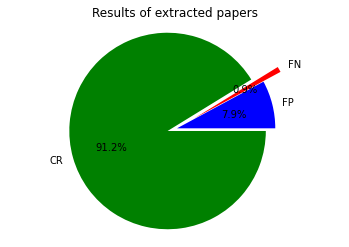

In [8]:
import matplotlib.pyplot as plt

labels = 'FP', 'FN', 'CR'
colors = 'blue', 'red', 'green'
explode = (0, 0.2, 0.1) 
sizes = [x for x in measures.values()]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, colors=colors)
ax1.axis('equal')

ax1.set_title("Results of extracted papers")
plt.show()

استخراج ایمیل های موجود در صفحه ی اول مقالات

In [9]:
searched_emails = {} # to store extracted emails for each paper

for paper_number in paper_numbers: # iterate over available paper numbers 
    searched_emails[paper_number] = [] # each paper has a list of emails

    txt_name = TXT_NAME_FORMAT.format(number=paper_number) # name of text file related to this paper, first page
    with open(PAPERS_TEXT_DIR+txt_name, 'r') as txt_file: # open the first page
        contents = ''.join([line.strip() for line in txt_file.readlines()]) # remove all spaces
        searched_emails[paper_number] = re.findall('[a-z][a-z0-9._-]*@[a-zA-Z\.]+\.[A-Za-z]{1,3}'\
                                            , contents.replace(' ', '')) # extract emails by regex

In [10]:
searched_emails

{'1': ['khaloo@sharif.edu', 'dehestani@civil.sharif.edu'],
 '14': ['shamsmohammadjavad@yahoo.com'],
 '167': ['hemmati@tums.ac.ir', 'mgodarzi@ut.ac.ir', 'ebhajiani@gmail.com'],
 '171': ['ommani75451@yahoo.com'],
 '172': ['makkipour@gmail.com'],
 '20': ['ramezani_masoud@yahoo.com'],
 '201': [],
 '24': ['j_firoozi@yahoo.com', 'tz.378945@gmail.com'],
 '25': [],
 '26': ['lale_20062006@yahoo.com'],
 '28': ['nakhaei.nas@gmail.Com'],
 '3': ['sahar.dehyouri@gmail.com'],
 '42': ['zhalezarei@yahoo.com', 'komijani@ut.ac.ir'],
 '43': [],
 '465': ['younes.goli67@gmail.com', 'derakhshan.haidary@yahoo.com'],
 '468': [],
 '469': [],
 '472': ['dr.haddadian@gmail.com'],
 '473': ['hamidieh@ut.ac.ir'],
 '474': ['lhoosh@alzahra.ac.ir'],
 '478': ['shirazi_b@yahoo.com'],
 '479': ['agherzadeh_eco58@yahoo.com', 'omijani@ut.ac.ir'],
 '480': ['nonahal@gmail.com'],
 '481': [],
 '6': ['allahyari@iaurasht.ac.ir'],
 '601': ['drsalehi@iausari.ac.ir', 'm.t_motamed@yahoo.com'],
 '62': ['drsalimpour@gmail.com'],
 '66': [

In [11]:
searched_affiliations

{'1': ['استاد سازه، دانشگاه صنعتی شریف تلفن ۱۹۱۹۶۲۱۰۲۱  ',
  ' دانشجوی دکتری، دانشگاه صنعتی شریف تلفن ۱۹۱۹۶۲۷۶-۰۲۱  '],
 '14': ['استادیار دانشگاه آزاد اسلامی، واحد اسلامشهر'],
 '167': ['فراگیر دکتری آینده پژوهی، پژوهشگاه علوم انسانی و مطالعات اجتماعی جهاد دانشگاهی، هیات علمی(مربی) دانشگاه علوم پزشکی تهران',
  'هیات علمی(استادیار دانشکده روانشناسی و علوم تربیتی دانشگاه تهران',
  'هیات علمی دانشیار پژوهشکده تحقیقات راهبردی مجمع تشخیص مصلحت نظام'],
 '171': ['استادیار دانشگاه آزاد اسلامی، واحد شوشتر، شوشتر، ایران',
  'دانش آموخته کارشناسی ارشد مدیریت کشاورزی، دانشگاه آزاد اسلامی، واحد شوشتر، شوشتر، ایران'],
 '172': [' کارشناس ارشد حسابداری، دانشگاه آزاد اسلامی، واحد علوم و تحقیقات، تهران، ایران. (مسئول مکاتبات)',
  ' استاد تمام حسابداری و مدیریت مالی ، دانشگاه شهید چمران، اهواز ، ایران.'],
 '20': ['عضو هیأت علمی دانشگاه آزاد اسلامی واحد اصفهان (خوراسگان)، ایران',
  'دانشجوی دکتری توسعه کشاورزی، دانشگاه رازی کرمانشاه، ایران',
  'دانشیار دانشکده کشاورزی، دانشگاه رازی کرمانشاه، ایران'],
 '201

In [12]:
final_dict = {}
with open('authors/paper3.txt') as author_file: # load author file to integrate with new section
            author_dict = json.load(author_file)
            final_dict = {"title":author_dict, \
                          "affiliations":searched_affiliations['3'],\
                          "emails":searched_emails['3']} # prepare the final result
final_dict

{'title': {'line': 2,
  'title_section_3': 'تاثیر فعالیت های ترویجی بر ارتقاء سطح دانش و مهارت کارشناسان و بهره برداران در زمینه فناوری های زیستی',
  'title_section_2': 'تاثیر فعالیت های ترویجی بر ارتقاء سطح دانش و مهارت کارشناسان \n و بهره برداران در زمینه فناوری های زیستی',
  'title_section_1': 'ﺗﺎﺛﻴﺮ ﻓﻌﺎﻟﻴﺖ ﻫﺎی ﺗﺮوﻳﺠﻲ ﺑﺮ ارﺗﻘﺎء ﺳﻄﺢ داﻧﺶ و ﻣﻬﺎرت ﻛﺎرﺷﻨﺎﺳﺎن و ﺑﻬﺮه ﺑﺮداران در زﻣﻴﻨﻪ ﻓﻨﺎوری ﻫﺎی زﻳﺴﺘﻲ',
  'authors': ['مسعود عرب خابوری', 'حمید رضا زمانی زاده', 'سحر دہ یوری']},
 'affiliations': ['کارشناسی ارشد ترویج و آموزش کشاورزی',
  'دانشیار دانشگاه آزاد اسلامی واحد علوم و تحقیقات تهران',
  'دانشجوی دکتری دانشگاه آزاد اسلامی واحد علوم و تحقیقات تهران'],
 'emails': ['sahar.dehyouri@gmail.com']}

In [13]:
with open('out/output3.json', 'w') as f:
    json.dump(final_dict, f) # convert final result into json format